# Session 3: Damage analysis (buildings and electric power facilities)
You will learn how to create earthquake and tornado hazard by using IN-CORE in this session

## 1. Fragility curve and Mapping

Damage analyses use fragility curve sets to calculate the limit state and damage stsate. Mapping then determines which fragility curve set applying to which inventory. For example, a building that has certain number of stories could be mapped to a specific set of fragility curves.

In IN-CORE, A user can both upload a set of fragility curves and mapping to the DFR3 services, or use local curve and mapping set objects.

This section briefly shows how to access fragility curves. A detailed instrcution of how to create your own fragility entities and mapping entities will be covered in next workshop.

User can easily browsing and searching Fragility Curves and Mappings via [DFR3 Viewer](https://incore.ncsa.illinois.edu/DFR3Viewer)
![dfr3_viewer](lookup_fragility_id.png)

Analyses use DFR3 mapping sets from IN-CORE service to associate each element of a given set with one or more elements of a second set of DFR3 curves. In IN-CORE and pyIncore specifically, a building inventory (given set) is mapped to a (second) set of fragility curves.

Please note that in this notebook we use term *function* in programming context as a class function and *curve* as a function in mathematical context (lognormal curve).

In [3]:
# import pyIncore modules
from pyincore import FragilityService, IncoreClient, FragilityCurveSet, MappingSet

# Connect to IN-CORE service
client = IncoreClient()

# Initalize a FragilityService
fragility_services = FragilityService(client)

Connection successful to IN-CORE services. pyIncore version detected: 0.9.3


In [4]:
# Getting a fragility curve and metadata
# You can see the curve with this ID at DFR3 viewer
fragility_set_id = "5b47b2d7337d4a36187c61ce"

# Get local fragility curve set
fragility_curve_set = FragilityCurveSet(fragility_services.get_dfr3_set(fragility_set_id))
fragility_curve_set.fragility_curves

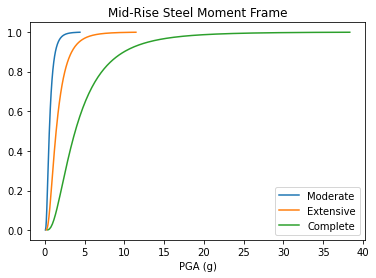

In [5]:
# visualize this fragility curve using pyincore-viz package
from pyincore_viz.plotutil import PlotUtil as plot

plt = plot.get_fragility_plot(fragility_curve_set, title="Mid-Rise Steel Moment Frame")
plt.show()

## 2. Buiding Inventory Data

The schema (columns) of building Inventory has been going through several iteration (v5, v6, v7), and here is a list of supported column names in version 6. Having a fully populated Building Inventory, with no additional columns, will hold all the data needed to perform all analyses that are compatible with that version of the Building Inventory.

|column name|description|type|
|-----------|-----------|----|
|GUID|added by IN-CORE|string|
|ARCHETYPE| building structure archetype|integer|
|OCC_TYPE|Broad HAZUS Occupancy Category (e.g. RES3 - multi-family residential)|string|
|APPR_BLDG|Appraised value for the building|double|
|SQ_FOOT|total building area in square feet|integer|
|DWELL_UNIT|total number of dwelling units in the building|integer|
|NO_STORIES|total number of stories for the building|integer|
|CONT_VAL|value of building contents|double|
|STR_TYP2|detailed structure type as per HAZUS MR-3 specifications|string|
|EFACILITY|essential facility designation|string|
|PAR_ID|parcel identifier|string|
|PARID_CARD|improvement identifier|string|
|BLDG_ID|building identifier (unique)|string|
|STR_PROB|probability that the structure type specified is correct|double|
|YEAR_BUILT|the year the structure was built|integer|
|A_STORIES|the number of above ground stories|integer|
|B_STORIES|the number of below ground stories|integer|
|BSMT_TYPE|the basement type|string|
|GSQ_FOOT|total ground floor area of the building in square feet|integer|
|OCC_DETAIL|"specific occupancy category, describing the detailed use of the building"|string|
|MAJOR_OCC|major occupancy category for the parcel in which the building is sited|string|
|BROAD_OCC|general occupancy categories|string|
|REPL_CST|replacement cost for the building from R.S. means square foot cost|double|
|STR_CST|structural component of the replacement cost|double|
|NSTRA_CST|acceleration sensitive component of replacement cost|double|
|NSTRD_CST|drift sensitive component of replacement cost|double|
|DGN_LVL|design level for the building as per HAZUS MR-3 specifications|string|
|OCC_TYP2|detailed HAZUS occupancy category for the building|string|
|TRACT_ID|census tract identifier|string|

There are many ways to create building inventory dataset; for example 1) using GIS software (e.g. ArcGIS, QGIS, etc), python code. 

In this exerercise, we will create a buiding inventory dataset in ESRI Shapefile from CSV file by using GeoPanda library.

Any analysis in pyIncore, by default uses **Dataset Object** as an input. Hence we have to <u>convert building dataset into pyincore dataset object</u>, in order to use it as an input for damage analysis. We can either upload the dataset to IN-CORE data services, using existing dataset id from the services, or using local files. The below introduces the basic concept of creating and using Dataset Object via either loading from local files, or connecting to remote IN-CORE Data Services.

### 2.1. Create a dataset from IN-CORE Data Service

A dataset can be created from data service with an id. pyIncore has utility methods to download the files and metadata from the data service to create a dataset obejct in local.


In [6]:
# Initialize a Data Serivce
from pyincore import DataService, Dataset

data_services = DataService(client)

# Loading dataset from Data Service
# See Data browser
building_dataset_id = "5a284f0bc7d30d13bc081a28"
buildings = Dataset.from_data_service(building_dataset_id, data_services)
buildings.metadata

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


{'id': '5a284f0bc7d30d13bc081a28',
 'deleted': False,
 'title': 'Hospitals',
 'description': '',
 'date': '2017-12-06T20:11:55+0000',
 'creator': 'ergo',
 'spaces': ['ergo'],
 'contributors': [],
 'fileDescriptors': [{'id': '5a284f0bc7d30d13bc081a2b',
   'deleted': False,
   'filename': 'all_bldgs_ver5_WGS1984.dbf',
   'mimeType': 'application/octet-stream',
   'size': 10859,
   'dataURL': '5a/28/5a284f0bc7d30d13bc081a2b/all_bldgs_ver5_WGS1984.dbf',
   'md5sum': '7ea0a4c769ca254a6b4821f2e737eb35'},
  {'id': '5a284f0bc7d30d13bc081a2e',
   'deleted': False,
   'filename': 'all_bldgs_ver5_WGS1984.fix',
   'mimeType': 'application/octet-stream',
   'size': 277,
   'dataURL': '5a/28/5a284f0bc7d30d13bc081a2e/all_bldgs_ver5_WGS1984.fix',
   'md5sum': '15c08cc1fac086265cb57ceac0785acb'},
  {'id': '5a284f0bc7d30d13bc081a31',
   'deleted': False,
   'filename': 'all_bldgs_ver5_WGS1984.prj',
   'mimeType': 'application/octet-stream',
   'size': 205,
   'dataURL': '5a/28/5a284f0bc7d30d13bc081a31/a

### 2.2 Create a local dataset of building inventory

A dataset can be created from local files. We will create a buidling inventory data in ESRI shapefile from CSV file according to building inventory schema. With the files, we will create a local dataset object.


#### Step 1: Convert CSV file to ESRI Shapefile

Open CSV file in the file browser to see the contents.

In [7]:
# Load CSV file into GeoPandas, then export the GeoDataFrame to ESRI shapefile

import pandas as pd
import geopandas as gpd

df = pd.read_csv('ergo_memphis_hospitals.csv')

gdf = gpd.GeoDataFrame(df, crs='epsg:4326', geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.to_file("sample_bldgs.shp")

#### Step 2: Add GUID
Each built-in infrastructure needs a GUID. 

In [8]:
# pyincore has utility methods help user easily add GUID
from pyincore import GeoUtil

GeoUtil.add_guid("sample_bldgs.shp", "sample_bldgs_w_guid.shp")

True

#### Step 3: Create a local dataset for IN-CORE
The following code create a local Dataset object with ESRI shapefile for buiding inventory 

In [9]:
local_buildings = Dataset.from_file("sample_bldgs_w_guid.shp", data_type="ergo:buildingInventoryVer7")

## 3. Building Damage Analysis
This analysis computes building damage based on a particular hazard. In this secion, you will perform building damage anlayis for both **scenario earthquake** and **tornado**.

The process for computing the structural damage is similar to other parts of the built environment. First, a fragility
is obtained based on the hazard type and attributes of the building. Based on the fragility, the hazard intensity at the location of the building is computed. Using this information, the probability of exceeding each limit state is computed, along with the probability of damage. For the case of an earthquake hazard, soil information can be used to
modify the damage probabilities to include damage due to liquefaction.  

The outputs of this analysis are CSV file with probabilities of damage and JSON file with information about hazard and fragilities.

**Input parameters**

key name | type | name | description
--- | --- | --- | ---
`result_name` <sup>*</sup> | `str` | Result name | Name of the result dataset.
`hazard_type` <sup>*</sup> | `str` | Hazard type | Hazard type (earthquake, tsunami, tornado, hurricaneWindfields).
`hazard_id` <sup>*</sup> | `str` | Hazard id | ID of the hazard from the Hazard service.
`fragility_key` | `str` | Fragility key | Fragility key used in mapping dataset.
`use_liquefaction` | `bool` | Liquefaction | Use liquefaction, if applicable to the hazard. <br>Default is *False*.
`use_hazard_uncertainty` | `bool` | Uncertainty | Use hazard uncertainty. <br>Default is *False*.
`num_cpu` | `int` | Number of CPUs | Number of CPUs used for parallel computation. <br>Default is *1*.

**Input datasets**

key name | type | name | description
--- | --- | --- | ---
`buildings` <sup>*</sup> | `ergo:buildingInventoryVer4`<br>`ergo:buildingInventoryVer5`<br>`ergo:buildingInventoryVer6`<br>`ergo:buildingInventoryVer7` | Building dataset |  A building dataset.
`dfr3_mapping_set` <sup>*</sup> | `incore:dfr3MappingSet` | DFR3 Mapping Set | DFR3 Mapping Set.

**Output datasets**

key name | type | parent key | name | description
--- | --- | --- | --- | ---
`ds_result` <sup>*</sup> | `ergo:buildingDamageVer5` | `buildings` | Results | A dataset containing results <br>(format: CSV).
`damage_result` <sup>*</sup> | `incore:buildingDamageSupplement` | `buildings` | Results | Information about applied hazard value and fragility<br>(format: JSON).

<small>(* required)</small>

In [10]:
# import building damage analysis class
from pyincore.analyses.buildingdamage import BuildingDamage

### 3.1 Damage analysis with earthquake

In [11]:
# Define the variables to be used for input parameters

hazard_type = "earthquake"
hazard_id = "5b902cb273c3371e1236b36b"

result_name = "memphis_eq_bldg_dmg_result"

# Default Building Fragility mapping
mapping_id = "5b47b350337d4a3629076f2c"

In [12]:
# create fragility mapping object with id
eq_mapping_set = MappingSet(fragility_services.get_mapping(mapping_id))

In [13]:
# Create building damage analysis object
eq_bldg_dmg = BuildingDamage(client)

# Load local dataset (building inventory)
eq_bldg_dmg.set_input_dataset("buildings", local_buildings)

# Load fragility mapping
eq_bldg_dmg.set_input_dataset("dfr3_mapping_set", eq_mapping_set)

eq_bldg_dmg.set_parameter("result_name", result_name)
eq_bldg_dmg.set_parameter("hazard_type", hazard_type)
eq_bldg_dmg.set_parameter("hazard_id", hazard_id)
eq_bldg_dmg.set_parameter("num_cpu", 1)

True

In [14]:
# Run building damage analysis
eq_bldg_dmg.run_analysis()

True

In [15]:
# more viz will be in next secsion
eq_bldg_dmg_table = eq_bldg_dmg.get_output_dataset("ds_result").get_dataframe_from_csv()
eq_bldg_dmg_table.head()

guid      LS_0      LS_1          LS_2  \
0  9e306063-02db-4c2e-ad72-d9da2287cdb0  0.848149  0.327322  2.722964e-02   
1  a4e29116-65d5-4f2a-8be8-92f6910f2454  0.844343  0.328299  2.860543e-02   
2  16e1983d-43f9-4e0b-ba59-6ec0f108fba0  0.896774  0.480925  8.756720e-02   
3  1b1c4c94-0c31-405d-9df5-84257debd204  0.828098  0.293753  2.738378e-02   
4  dd7d8779-1f48-450f-9c27-3ab9d986c626  0.970343  0.154677  1.000000e-10   

       DS_0      DS_1      DS_2          DS_3  
0  0.151851  0.520827  0.300092  2.722964e-02  
1  0.155657  0.516043  0.299694  2.860543e-02  
2  0.103226  0.415849  0.393358  8.756720e-02  
3  0.171902  0.534345  0.266369  2.738378e-02  
4  0.029657  0.815666  0.154677  1.000000e-10

### 3.2 Damage analysis with tornado

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


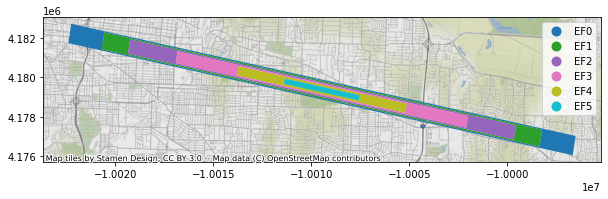

In [29]:
# Use tornado from IN-CORE Hazard Services
hazard_id = "60a44ae8605f0462bd4263ac"

# visualize the tornado using pyincore-viz package
from pyincore_viz.geoutil import GeoUtil as viz
viz.plot_tornado(hazard_id, client, basemap=True)

In [30]:
hazard_type = "tornado"
hazard_id = "60a44ae8605f0462bd4263ac"
result_name = "memphis_tornado_bldg_dmg_result"
tornado_mapping_id = "5d8942dfb9219c068ea795ea" # 19 archetype tornado mapping

In [31]:
# create fragility mapping object with id
tornado_mapping_set = MappingSet(fragility_services.get_mapping(tornado_mapping_id))

In [32]:
tornado_bldg_dmg = BuildingDamage(client)
tornado_bldg_dmg.set_input_dataset("buildings", local_buildings)

tornado_bldg_dmg.set_input_dataset('dfr3_mapping_set', tornado_mapping_set)

tornado_bldg_dmg.set_parameter("result_name", result_name)
tornado_bldg_dmg.set_parameter("hazard_type", hazard_type)
tornado_bldg_dmg.set_parameter("hazard_id", hazard_id)
tornado_bldg_dmg.set_parameter("num_cpu", 1)
tornado_bldg_dmg.run_analysis()

True

In [33]:
# more viz will be in next secsion
tornado_bldg_dmg_table = tornado_bldg_dmg.get_output_dataset("ds_result").get_dataframe_from_csv()
tornado_bldg_dmg_table.head()

guid      LS_0          LS_1  LS_2  \
0  9e306063-02db-4c2e-ad72-d9da2287cdb0  0.000000  0.000000e+00   0.0   
1  a4e29116-65d5-4f2a-8be8-92f6910f2454  0.000000  0.000000e+00   0.0   
2  16e1983d-43f9-4e0b-ba59-6ec0f108fba0  0.051066  2.400000e-09   0.0   
3  1b1c4c94-0c31-405d-9df5-84257debd204  0.000000  0.000000e+00   0.0   
4  dd7d8779-1f48-450f-9c27-3ab9d986c626  0.000000  0.000000e+00   0.0   

       DS_0      DS_1          DS_2  DS_3  
0  1.000000  0.000000  0.000000e+00   0.0  
1  1.000000  0.000000  0.000000e+00   0.0  
2  0.948934  0.051066  2.400000e-09   0.0  
3  1.000000  0.000000  0.000000e+00   0.0  
4  1.000000  0.000000  0.000000e+00   0.0

## 4. Electric Power Facility Damage Analysis
This analysis computes electric power facility damage based on a particular hazard. In this secion, you will perform Electric Power Facility damage anlayis for both **scenario earthquake and tornado**

The process for computing the structural damage is similar to other parts of the built environment. First, a fragility
is obtained based on the hazard type and attributes of the electric power facility. Based on the fragility, the hazard intensity at the location of the electric power facility is computed. Using this information, the probability of exceeding each limit state is computed, along with the probability of damage. For the case of an earthquake hazard, soil information can be used to modify the damage probabilities to include damage due to liquefaction.  

The outputs of this analysis are CSV file with probabilities of damage and JSON file with information about hazard and fragilities.

**Input parameters**

key name | type | name | description
--- | --- | --- | ---
`result_name` <sup>*</sup> | `str` | Result name | Name of the result dataset.
`hazard_type` <sup>*</sup> | `str` | Hazard type | Hazard type (earthquake, tsunami, tornado, hurricaneWindfields). 
`hazard_id` <sup>*</sup> | `str` | Hazard id | ID of the hazard from the Hazard service.
`fragility_key` | `str` | Fragility key | Fragility key used in mapping dataset.
`use_liquefaction` | `bool` | Liquefaction | Use liquefaction, if applicable to the hazard. <br>Default is *False*.
`use_hazard_uncertainty` | `bool` | Uncertainty | Use hazard uncertainty. <br>Default is *False*.
`num_cpu` | `int` | Number of CPUs | Number of CPUs used for parallel computations. <br>Default *1*.

**Input datasets**

key name | type | name | description
--- | --- | --- | ---
`epfs` <sup>*</sup> | `incore:epf`<br>`ergo:epf` | Electric power dataset | An electric power facility dataset.
`dfr3_mapping_set` <sup>*</sup> | `incore:dfr3MappingSet` | DFR3 Mapping Set | DFR3 Mapping Set.

**Output datasets**

key name | type | parent key | name | description
--- | --- | --- | --- | ---
`result` <sup>*</sup> | `incore:epfDamageVer2` |`epfs` | Results | A dataset containing results <br>(format: CSV).
`damage_result` <sup>*</sup> | `epfDamageSupplement` | `epfs` | Results | Information about applied hazard value and fragility<br>(format: JSON).

<small>(* required)</small>

In [34]:
# import EPF damage class
from pyincore.analyses.epfdamage import EpfDamage

### 3.1 Damage analysis with earthquake

In [35]:
# Seaside earthquake AtkinsonBoore1995
hazard_type = "earthquake"
hazard_id = "5d3b6a31b9219cf53284c73d"

# Seaside Electric power facility dataset; use remote dataset from INCORE services
epf_dataset_id = "5d263f08b9219cf93c056c68"

# Earthquake epf mapping
mapping_id = "5d489aa1b9219c0689f1988e"

result_name = "hazus_epf_dmg_result"

In [36]:
eq_epf_dmg = EpfDamage(client)
eq_epf_dmg.load_remote_input_dataset("epfs", epf_dataset_id)

# Load fragility mapping
epf_eq_mapping_set = MappingSet(fragility_services.get_mapping(mapping_id))
eq_epf_dmg.set_input_dataset("dfr3_mapping_set", epf_eq_mapping_set)

eq_epf_dmg.set_parameter("result_name", result_name)
eq_epf_dmg.set_parameter("hazard_type", hazard_type)
eq_epf_dmg.set_parameter("hazard_id", hazard_id)
eq_epf_dmg.set_parameter("num_cpu", 1)

# Run Analysis
eq_epf_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [37]:
# more viz will be in next secsion
eq_epf_bldg_dmg_table = eq_epf_dmg.get_output_dataset("result").get_dataframe_from_csv()
eq_epf_bldg_dmg_table.head()

guid      LS_0      LS_1      LS_2  \
0  c34c4207-d1e8-47d1-b29e-1ba11d951bce  0.999989  0.999982  0.999997   
1  402388b9-f14c-4402-9ad9-8b0965de0937  1.000000  1.000000  1.000000   
2  1d244334-1aef-4ced-b5f5-6f886a9d0db6  1.000000  1.000000  1.000000   
3  5a051ea9-a0b3-45ee-a283-82512e7b7cb6  1.000000  1.000000  1.000000   
4  51a54596-597b-46f9-8c8b-bc58f1105853  1.000000  1.000000  1.000000   

       LS_3      DS_0  DS_1  DS_2          DS_3      DS_4  
0  0.994662  0.005338   0.0   0.0  5.334768e-03  0.994662  
1  1.000000  0.000000   0.0   0.0  4.800000e-08  1.000000  
2  1.000000  0.000000   0.0   0.0  2.700000e-09  1.000000  
3  1.000000  0.000000   0.0   0.0  2.300000e-09  1.000000  
4  1.000000  0.000000   0.0   0.0  2.500000e-09  1.000000

### 3.2 Damage analysis with tornado

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


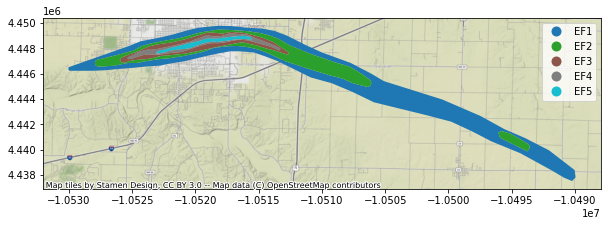

In [38]:
hazard_type = "tornado"
hazard_id = "5d07cbeab9219c065b080930"  # The simulated EF-5 tornado shows geographical locations and the range
                                        # of wind speed of tornado hazard in Joplin.

# visualize the tornado using pyincore-viz package
viz.plot_tornado(hazard_id, client, basemap=True)

In [39]:
hazard_type = "tornado"
hazard_id = "5d07cbeab9219c065b080930"  # The simulated EF-5 tornado shows geographical locations and the range
                                        # of wind speed of tornado hazard in Joplin.
    
epf_substations_id = "5d92355bb9219c06ae7e386a"
mapping_id = "5d8a326fb9219c068ea798e7"  # Create a mapping to assign tornado fragilities to substations.
result_name = "Joplin_epf_substations_dmg_result"

In [40]:
tornado_epf_mapping_set = MappingSet(fragility_services.get_mapping(mapping_id))
epf_sub_dmg = EpfDamage(client)
epf_sub_dmg.load_remote_input_dataset("epfs", epf_substations_id)
epf_sub_dmg.set_input_dataset("dfr3_mapping_set", tornado_epf_mapping_set)
epf_sub_dmg.set_parameter("result_name", result_name)
epf_sub_dmg.set_parameter("hazard_type", hazard_type)
epf_sub_dmg.set_parameter("hazard_id", hazard_id)
epf_sub_dmg.set_parameter("num_cpu", 4)
epf_sub_dmg.set_parameter("fragility_key", "substations")
epf_sub_dmg.run_analysis()  # Run the EPF damage module to get substations damage results for Joplin in a .csv file format. The
                            # substations damage results herein are referred to fragilities at four damage states (insignificant,
                            # moderate, extensive, complete) for 18 substations located in Joplin that fall within the tornado
                            # path or not.

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [41]:
# more viz will be in next secsion
substation_dmg_result = epf_sub_dmg.get_output_dataset('result')
df_sub_dmg = substation_dmg_result.get_dataframe_from_csv()
df_sub_dmg.head()

guid  LS_0  LS_1  LS_2  LS_3  DS_0  DS_1  \
0  7f426763-81c6-4cac-b98d-c37a5e439b90   0.0   0.0   0.0   0.0   1.0   0.0   
1  fc8add00-6760-4752-b1fb-7d6ca813f535   0.0   0.0   0.0   0.0   1.0   0.0   
2  e8f4939d-763f-4743-bc61-c23e0b8e0f7a   0.0   0.0   0.0   0.0   1.0   0.0   
3  2cab48ff-c5ce-495e-9662-67c9a177efc4   0.0   0.0   0.0   0.0   1.0   0.0   
4  eb4ce929-5164-4ebf-ace2-708096d89db5   0.0   0.0   0.0   0.0   1.0   0.0   

   DS_2  DS_3  DS_4  
0   0.0   0.0   0.0  
1   0.0   0.0   0.0  
2   0.0   0.0   0.0  
3   0.0   0.0   0.0  
4   0.0   0.0   0.0

## 5. Combine/compare damage output with different hazard types

In [42]:
comparison = eq_bldg_dmg_table.merge(tornado_bldg_dmg_table, how="outer", on="guid", suffixes=('_eq', '_tornado'))
comparison.head()

guid   LS_0_eq   LS_1_eq       LS_2_eq  \
0  9e306063-02db-4c2e-ad72-d9da2287cdb0  0.848149  0.327322  2.722964e-02   
1  a4e29116-65d5-4f2a-8be8-92f6910f2454  0.844343  0.328299  2.860543e-02   
2  16e1983d-43f9-4e0b-ba59-6ec0f108fba0  0.896774  0.480925  8.756720e-02   
3  1b1c4c94-0c31-405d-9df5-84257debd204  0.828098  0.293753  2.738378e-02   
4  dd7d8779-1f48-450f-9c27-3ab9d986c626  0.970343  0.154677  1.000000e-10   

    DS_0_eq   DS_1_eq   DS_2_eq       DS_3_eq  LS_0_tornado  LS_1_tornado  \
0  0.151851  0.520827  0.300092  2.722964e-02      0.000000  0.000000e+00   
1  0.155657  0.516043  0.299694  2.860543e-02      0.000000  0.000000e+00   
2  0.103226  0.415849  0.393358  8.756720e-02      0.051066  2.400000e-09   
3  0.171902  0.534345  0.266369  2.738378e-02      0.000000  0.000000e+00   
4  0.029657  0.815666  0.154677  1.000000e-10      0.000000  0.000000e+00   

   LS_2_tornado  DS_0_tornado  DS_1_tornado  DS_2_tornado  DS_3_tornado  
0           0.0      1.000000      0.000000  0.000000e+00           0.0  
1           0.0      1.000000      0.000000  0.000000e+00           0.0  
2           0.0      0.948934      0.051066  2.400000e-09           0.0  
3           0.0      1.000000      0.000000  0.000000e+00           0.0  
4           0.0      1.000000      0.000000  0.000000e+00           0.0

## Hands-on Assignment

Please open [session3-assignment.ipynb](session3-assignment.ipynb)
